In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import cv2

class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        
        cap = cv2.VideoCapture(filename)

        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            try:
              frame = cv2.resize(frame, (self.height, self.width))
            except:
              print("break here")
              break
        
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        
        return np.array(framearray)

In [4]:
import argparse
import os

import matplotlib
matplotlib.use('AGG')

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import cifar10
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,
                          MaxPooling3D)

from keras.layers import ELU, PReLU, LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from keras.callbacks import ModelCheckpoint

##
import tensorflow as tf
from keras.backend import set_session


def loaddata(video_dir, vid3d, nclass, color=False, skip=True):
    
    files = os.listdir(video_dir)  
    X = []
    labels = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]

    pbar = tqdm(total=len(files))

    for filename in files:
    
        pbar.update(1)
        
        name = os.path.join(video_dir, filename)
            
        X.append(vid3d.video3d(name, color=color, skip=skip))

    pbar.close()

    if color:
        #return np.array(X).transpose((0, 2, 3, 4, 1)), labels
        return np.array(X), labels
    else:
        #return np.array(X).transpose((0, 2, 3, 1)), labels
        return np.array(X), labels

100%|██████████| 20/20 [08:15<00:00, 24.78s/it]


X_shape:(20, 32, 32, 200, 3)
Y_shape:(20, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 200, 32)   2624      
                                                                 
 activation (Activation)     (None, 32, 32, 200, 32)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 200, 32)   27680     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 200, 32)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 11, 11, 67, 32)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 67, 32)    0         
           

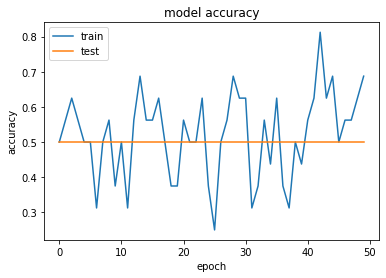

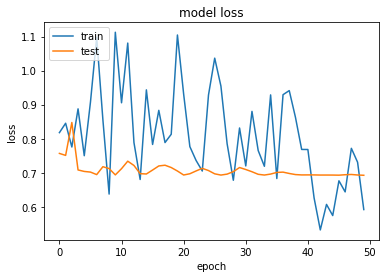

In [5]:
depth = 200
img_rows, img_cols, frames = 32, 32, depth
channel = 3 
batch = 128
epoch = 50
videos = '/content/drive/MyDrive/BDD/20/'
color = True
skip = False
nclass = 2

vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = 2

x, y = loaddata(videos, vid3d, nclass, color, skip)
X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
Y = np_utils.to_categorical(y,num_classes=nb_classes)

X = X.astype('float32')
    
print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

# Define model
model = Sequential()
   
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(
    X.shape[1:]), padding='same'))

# model.add(Activation('relu'))
# model.add(Conv3D(32, kernel_size=(3, 3, 3), border_mode='same'))
# model.add(Activation('softmax'))
# model.add(MaxPooling3D(pool_size=(3, 3, 3), border_mode='same'))
# model.add(Dropout(0.25))



model.add(Activation('relu'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('softmax'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('softmax'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
model.summary()

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=43)


    # Train model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch,
                    epochs=epoch, verbose=1, shuffle=True)
    
model.evaluate(X_test, Y_test, verbose=0)

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    
print('Test loss:', loss)
print('Test accuracy:', acc)

# summarize history for accuracy
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()